In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load EUR/USD , GBP/USD  and Gas Price data
df1 = pd.read_csv('EURUSD_Candlestick_1_Hour.csv')
df2 = pd.read_csv('GBPUSD_Candlestick_1_Hour.csv')
df3 = pd.read_csv('GAS.CMDUSD_Candlestick_1_D_BID.csv')
df3 = df3.iloc[1:]

# Function to clean and convert datetime
def clean_datetime(df, time_column):
    # Remove " GMT+0100" from the datetime string
    df[time_column] = df[time_column].str.replace(r" GMT[+-]\d{4}", "", regex=True)

    # Convert to datetime
    df[time_column] = pd.to_datetime(df[time_column], format="%d.%m.%Y %H:%M:%S.%f", errors='coerce')

    # Set as index
    df.set_index(time_column, inplace=True)

    return df

# Clean and process the datasets
df1 = clean_datetime(df1, 'Local time')
df2 = clean_datetime(df2, 'Local time')
df3 = clean_datetime(df3, 'Local time')

# Resample hourly data to daily (taking the last price for each day)
df1 = df1.resample('D').last()
df2 = df2.resample('D').last()

# Fix Natural Gas timestamps by normalizing to 00:00:00 UTC
df3.index = df3.index.normalize()

# Forward-fill missing data for consistency
df1.ffill(inplace=True)
df2.ffill(inplace=True)
df3.ffill(inplace=True)


df1['Simple_Return'] = df1['Close'].pct_change()
df2['Simple_Return'] = df2['Close'].pct_change()
df3['Simple_Return'] = df3['Close'].pct_change()

# Drop NaN values introduced by shifting
returns = pd.concat([df1['Simple_Return'], df2['Simple_Return'], df3['Simple_Return']], axis=1)
returns.columns = ['EURUSD', 'GBPUSD', 'NATGAS']
returns.dropna(inplace=True)

# Historical Returns
print(returns)

# Compute mean and standard deviation of returns
mean_returns = returns.mean()*252
std_dev = returns.std()*np.sqrt(252)

print("Annualized Returns:\n", mean_returns)
print("\nAnnualized Standard Deviation:\n", std_dev)





              EURUSD    GBPUSD    NATGAS
Local time                              
2024-01-02 -0.009363 -0.008487  0.044125
2024-01-03 -0.001810  0.003709  0.060015
2024-01-04  0.002353  0.001571  0.020057
2024-01-05 -0.000649  0.002578  0.000000
2024-01-06  0.000000  0.000000  0.000000
...              ...       ...       ...
2024-12-27 -0.000086  0.003801  0.000000
2024-12-28  0.000000  0.000000  0.000000
2024-12-29  0.000787  0.000223  0.148282
2024-12-30 -0.002531 -0.002919 -0.071332
2024-12-31 -0.004969 -0.002138  0.000000

[365 rows x 3 columns]
Annualized Returns:
 EURUSD   -0.043409
GBPUSD   -0.010418
NATGAS    0.410575
dtype: float64

Annualized Standard Deviation:
 EURUSD    0.049206
GBPUSD    0.052139
NATGAS    0.587413
dtype: float64


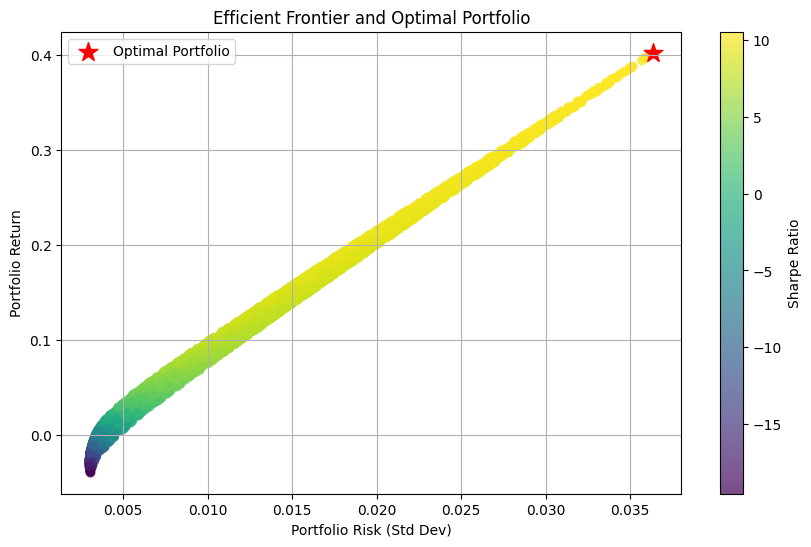

    Asset  Optimal Weight
0  EURUSD        0.012546
1  GBPUSD        0.004931
2  NATGAS        0.982523


In [ ]:

# the covariance matrix of assets
cov_matrix = returns.cov()
# Number of portfolios to simulate
num_portfolios = 10000
risk_free_rate = 0.02  # Assumed annualized risk-free rate

# Arrays to store results
port_returns = []
port_risks = []
sharpe_ratios = []
weights_list = []

# Simulate random portfolios
for _ in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)

    # Portfolio return and risk
    port_return = np.sum(weights * mean_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_risk

    port_returns.append(port_return)
    port_risks.append(port_risk)
    sharpe_ratios.append(sharpe_ratio)
    weights_list.append(weights)

# Convert results to arrays
port_returns = np.array(port_returns)
port_risks = np.array(port_risks)
sharpe_ratios = np.array(sharpe_ratios)

# Find the optimal portfolio (max Sharpe ratio)
max_sharpe_idx = np.argmax(sharpe_ratios)
optimal_weights = weights_list[max_sharpe_idx]
optimal_return = port_returns[max_sharpe_idx]
optimal_risk = port_risks[max_sharpe_idx]

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(port_risks, port_returns, c=sharpe_ratios, cmap="viridis", alpha=0.7)
plt.colorbar(label="Sharpe Ratio")
plt.scatter(optimal_risk, optimal_return, c="red", marker="*", s=200, label="Optimal Portfolio")
plt.xlabel("Portfolio Risk (Std Dev)")
plt.ylabel("Portfolio Return")
plt.title("Efficient Frontier and Optimal Portfolio")
plt.legend()
plt.grid(True)
plt.show()

# Display the optimal portfolio allocation
optimal_allocation = pd.DataFrame(
    {"Asset": mean_returns.index, "Optimal Weight": optimal_weights}
)
print(optimal_allocation)



Correlation Matrix:
           EURUSD    GBPUSD    NATGAS
EURUSD  1.000000  0.786948  0.045696
GBPUSD  0.786948  1.000000  0.048046
NATGAS  0.045696  0.048046  1.000000


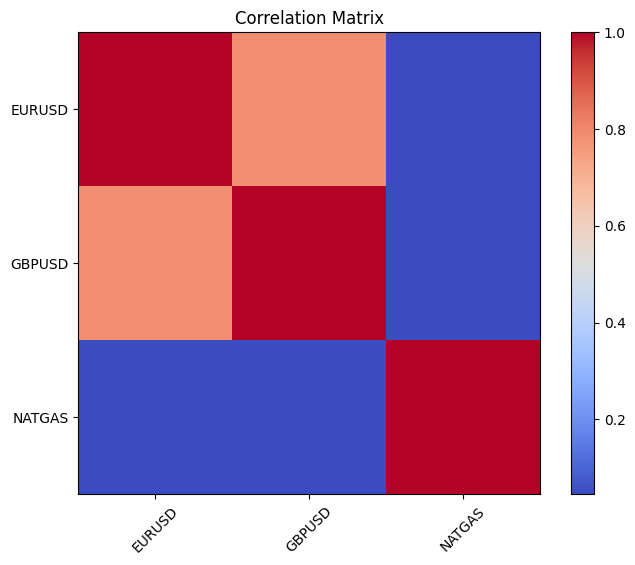

In [ ]:
#  Analyze correlations
correlation_matrix = returns.corr()  # Compute correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

## Discussion: Risk-Adjusted Returns, Correlation between assets and diversification benefits


### 1. How Correlation Affects Portfolio Allocation
Not all assets react the same way to market events. This is where **correlation** comes into play:
- **Correlation close to +1** → Assets move in the same direction.
- **Correlation close to 0** → Assets move independently.
- **Correlation close to -1** → When one rises, the other falls.

Adding **low or negatively correlated assets** helps reduce the overall volatility of the portfolio.

In our case:
- **EUR/USD and GBP/USD are highly correlated** → Little diversification between them.
- **Natural Gas has low correlation with the currencies** → Provides better diversification.

This is why the portfolio optimization assigns a **very high weight to Natural Gas**, around **98.25%**, while **EUR/USD and GBP/USD receive only 1.25% and 0.49%, respectively**. Natural Gas helps reduce overall risk without significantly sacrificing returns.



### 2. Diversification: A Key Tool for Reducing Risk
The goal is to reduce risk without losing too much return. Mathematically, the **total portfolio risk** is given by:

$$ \sigma_p^2 = \sum w_i^2 \sigma_i^2 + \sum \sum w_i w_j \rho_{ij} \sigma_i \sigma_j $$

where:
- $w_i, w_j $ are the **weights of the assets**,
- $\sigma_i, \sigma_j $ are the **volatilities of the assets**,
- $ \rho_{ij} $ is the **correlation between assets \(i\) and \(j\)**.

If an asset has **low correlation with others**, it helps reduce overall volatility. **This is the case for Natural Gas here**, explaining its high weight in the optimization.


### 3. Conclusion
- **Optimization favors low-correlation assets** to reduce overall risk.
- **EUR/USD and GBP/USD are too correlated** to provide significant diversification benefits.
- **Natural Gas plays a key role** in balancing risk and return in the portfolio, explaining its dominant allocation.

If constraints are imposed (e.g., limiting Natural Gas to 50%), the allocation would change.


 #### **Follow-Up Questions**


**Question 1:** How would you adjust the portfolio for changing market conditions?




**Answer:** By actively rebalancing, monitoring correlations, adjusting for volatility, incorporating economic insights, stress testing, diversifying, and maintaining liquidity, we can navigate market shifts while optimizing risk-adjusted returns.

**Question 2:**: How do you incorporate transaction costs into portfolio optimization?

**Answer:**


By Adjusting the Objective Function in the optimization problem for Transaction Costs

In traditional **Mean-Variance Optimization (MVO)**, the objective is:

$$
\max \left( \frac{E[R_p] - R_f}{\sigma_p} \right)
$$

To include transaction costs, we modify the function to:

$$
\max \left( \frac{E[R_p] - R_f - C_p}{\sigma_p} \right)
$$

where $C_p$ represents the total transaction costs for the portfolio.







**Question 3:** How would you optimize the portfolio using a dynamic strategy instead of a static allocation?


**Answer:**



### 1. Time-Varying Mean-Variance Optimization (TV-MVO)
- Uses **rolling windows** and **adaptive models** to update expected returns and risks.
- Example: If Natural Gas becomes volatile, the model **reduces its weight** and shifts toward forex pairs.



### 2. Machine Learning
- Uses **AI-driven models** to optimize portfolio allocation dynamically.
- Example: If EUR/USD shows **strong momentum**, the model **increases its weight** while reducing weaker assets.



